# NIP Final Project: Random Feedback Alignment (RFA)

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import matplotlib.pyplot as plt


## Preparing the Dataset

In [2]:
# Make sure model and data are both on either cpu or gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Preparing the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load full MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Reduce training dataset to 20.000 examples
num_examples = 20000
indices = torch.randperm(len(train_dataset))[:num_examples] 
train_subset = Subset(train_dataset, indices)
 

#### Input Whitening

In [4]:
# Whitening
images = []
labels = []

for img, label in train_subset:
    flat_img = img.view(-1)  # Flatten to shape (784,)
    images.append(flat_img)
    labels.append(label)

input_train = torch.stack(images)   # Shape: (20000, 784)
output_train = torch.tensor(labels)  # Shape: (20000,)

# Compute the mean vector (per feature/pixel)
mean = input_train.mean(dim=0, keepdim=True)  # shape: (1, 784)

# Center the data (zero mean)
input_centered = input_train - mean

# Compute covariance matrix
cov = input_centered.T @ input_centered / (input_centered.shape[0] - 1)  # shape: (784, 784)

# Eigen-decomposition (or SVD if preferred)
eigvals, eigvecs = torch.linalg.eigh(cov)  # eigvals: (784,), eigvecs: (784, 784)

# Build whitening matrix
epsilon = 1e-5  # for numerical stability
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(eigvals + epsilon))  # shape: (784, 784)
whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T  # shape: (784, 784)

# Apply whitening to training data
input_train_whitened = input_centered @ whitening_matrix  # shape: (20000, 784)

# Prepare test set (flatten, center with training mean, apply same whitening)
input_test = torch.stack([img.view(-1) for img, _ in test_dataset])
output_test = torch.tensor([label for _, label in test_dataset])
input_test_centered = input_test - mean  # use **training mean**
input_test_whitened = input_test_centered @ whitening_matrix

# Wrap whitened data in TensorDatasets for easy loading
train_whitened_dataset = TensorDataset(input_train_whitened, output_train)
test_whitened_dataset = TensorDataset(input_test_whitened, output_test)

In [5]:
# Dataloaders non-whitened
train_loader_normal = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_normal = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Dataloaders whitened
train_loader_whitened = DataLoader(train_whitened_dataset, batch_size = 64, shuffle = True)
test_loader_whitened = DataLoader(test_whitened_dataset, batch_size=1000, shuffle=False)

## Network Architecture

In [6]:
class MLP_RFA(nn.Module):
    def __init__(self, input_size=784, hidden1=256, hidden2=128, output_size=10): # 784 because MNIST images are 28x28 pixels
        super(MLP_RFA, self).__init__() # run all setup code of the parent class before adding custom parts, to make sure my class inherits its full functionality
        self.fc1 = nn.Linear(input_size, hidden1)  # first hidden layer
        self.fc2 = nn.Linear(hidden1, hidden2)     # second hidden layer
        self.fc3 = nn.Linear(hidden2, output_size) # output layer

    def forward(self, x):
        x = x.view(-1, 784)
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        out = self.fc3(h2)
        return out, h1, h2  # return activations for RFA


In [7]:
# Instantiate model
model = MLP_RFA().to(device)

In [8]:
# Create Feedback matrices: 10x256 tensor with random values from standard normal distribution with mean 0 and sd 0.1
B1 = torch.randn(10, 256, device=device) * 0.1 # Feedback Matrix for first hidden layer
B2 = torch.randn(10, 128, device=device) * 0.1 # Feedback Matrix for second hidden layer


## Training without whitening

In [9]:
# Training Loop with RFA NO Whitening

criterion = nn.CrossEntropyLoss() # Loss Function
lr = 5e-3 # Learning rate
train_losses_normal = []
test_accuracies_normal = []
gradient_alignments_normal = []


for epoch in range(30):
    epoch_loss = 0.0
    alignment_values_normal = []
    for data, target in train_loader_normal:
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output, h1, h2 = model(data)
        loss = criterion(output, target)
        
        # Compute true gradient with backprop to compare later
        model.zero_grad()
        loss.backward(retain_graph=True)  # Keep graph for manual update later
        true_grad_fc1_w = model.fc1.weight.grad.detach().clone() # (hidden_size, 784)

        
        # Zero gradients manually
        for param in model.parameters():
            param.grad = None

        # Compute output error
        e = torch.zeros_like(output)
        e[range(target.shape[0]), target] = 1 
        e = output.softmax(dim=1) - e  # cross-entropy gradient approximation

        # Compute gradients via random feedback alignment
        # Output layer gradients (standard)
        grad_fc3_w = torch.matmul(e.T, h2)
        grad_fc3_b = e.sum(0)

        # Hidden layer 2 gradients via B2
        delta_h2 = torch.matmul(e, B2) * (h2 > 0).float()
        grad_fc2_w = torch.matmul(delta_h2.T, h1)
        grad_fc2_b = delta_h2.sum(0)

        # Hidden layer 1 gradients via B1
        delta_h1 = torch.matmul(e, B1) * (h1 > 0).float()
        x_flat = data.view(-1, 784)
        grad_fc1_w = torch.matmul(delta_h1.T, x_flat)
        grad_fc1_b = delta_h1.sum(0)

        cos_sim = cosine_similarity(grad_fc1_w.view(1, -1), true_grad_fc1_w.view(1, -1), dim=1).item()
        alignment_values_normal.append(cos_sim)

        # Update weights manually
        model.fc3.weight.data -= lr * grad_fc3_w / data.size(0)
        model.fc3.bias.data   -= lr * grad_fc3_b / data.size(0)

        model.fc2.weight.data -= lr * grad_fc2_w / data.size(0)
        model.fc2.bias.data   -= lr * grad_fc2_b / data.size(0)

        model.fc1.weight.data -= lr * grad_fc1_w / data.size(0)
        model.fc1.bias.data   -= lr * grad_fc1_b / data.size(0)

        epoch_loss += loss.item() * data.size(0)

    avg_loss = epoch_loss / len(train_loader_normal.dataset)
    avg_alignment_normal = sum(alignment_values_normal) / len(alignment_values_normal)

    train_losses_normal.append(avg_loss)
    gradient_alignments_normal.append(avg_alignment_normal)
   

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader_normal:
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_acc = correct / total
    test_accuracies_normal.append(test_acc)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%, Gradient Alignment: {avg_alignment_normal:.4f}")
    model.train()


Epoch 1, Loss: 2.0300, Test Accuracy: 60.30%, Gradient Alignment: 0.1023
Epoch 2, Loss: 0.8773, Test Accuracy: 82.06%, Gradient Alignment: 0.3890
Epoch 3, Loss: 0.5717, Test Accuracy: 85.87%, Gradient Alignment: 0.5196
Epoch 4, Loss: 0.4815, Test Accuracy: 87.42%, Gradient Alignment: 0.5745
Epoch 5, Loss: 0.4371, Test Accuracy: 88.05%, Gradient Alignment: 0.6068
Epoch 6, Loss: 0.4075, Test Accuracy: 88.75%, Gradient Alignment: 0.6322
Epoch 7, Loss: 0.3874, Test Accuracy: 89.20%, Gradient Alignment: 0.6480
Epoch 8, Loss: 0.3704, Test Accuracy: 89.35%, Gradient Alignment: 0.6645
Epoch 9, Loss: 0.3582, Test Accuracy: 89.95%, Gradient Alignment: 0.6778
Epoch 10, Loss: 0.3460, Test Accuracy: 89.64%, Gradient Alignment: 0.6850
Epoch 11, Loss: 0.3386, Test Accuracy: 90.58%, Gradient Alignment: 0.6929
Epoch 12, Loss: 0.3300, Test Accuracy: 90.55%, Gradient Alignment: 0.6963
Epoch 13, Loss: 0.3233, Test Accuracy: 90.71%, Gradient Alignment: 0.7003
Epoch 14, Loss: 0.3167, Test Accuracy: 90.86%, 

## Training with whitening

In [10]:
# Training Loop with RFA WITH Whitenining

criterion = nn.CrossEntropyLoss() # Loss Function
lr = 5e-3 # Learning rate
train_losses_whitened = []
test_accuracies_whitened = []
gradient_alignments_whitened = []


for epoch in range(30):
    epoch_loss = 0.0
    alignment_values_whitened = []

    for data, target in train_loader_whitened:
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output, h1, h2 = model(data)
        loss = criterion(output, target)
        
        # Compute true gradient with backprop to compare later
        model.zero_grad()
        loss.backward(retain_graph=True)  # Keep graph for manual update later
        true_grad_fc1_w = model.fc1.weight.grad.detach().clone() # (hidden_size, 784)

        # Zero gradients manually
        for param in model.parameters():
            param.grad = None

        # Compute output error
        e = torch.zeros_like(output)
        e[range(target.shape[0]), target] = 1 
        e = output.softmax(dim=1) - e  # cross-entropy gradient approximation

        # Compute gradients via random feedback alignment
        # Output layer gradients (standard)
        grad_fc3_w = torch.matmul(e.T, h2)
        grad_fc3_b = e.sum(0)

        # Hidden layer 2 gradients via B2
        delta_h2 = torch.matmul(e, B2) * (h2 > 0).float()
        grad_fc2_w = torch.matmul(delta_h2.T, h1)
        grad_fc2_b = delta_h2.sum(0)

        # Hidden layer 1 gradients via B1
        delta_h1 = torch.matmul(e, B1) * (h1 > 0).float()
        x_flat = data.view(-1, 784)
        grad_fc1_w = torch.matmul(delta_h1.T, x_flat)
        grad_fc1_b = delta_h1.sum(0)

        cos_sim = cosine_similarity(grad_fc1_w.view(1, -1), true_grad_fc1_w.view(1, -1), dim=1).item()
        alignment_values_whitened.append(cos_sim)

        # Update weights manually
        model.fc3.weight.data -= lr * grad_fc3_w / data.size(0)
        model.fc3.bias.data   -= lr * grad_fc3_b / data.size(0)

        model.fc2.weight.data -= lr * grad_fc2_w / data.size(0)
        model.fc2.bias.data   -= lr * grad_fc2_b / data.size(0)

        model.fc1.weight.data -= lr * grad_fc1_w / data.size(0)
        model.fc1.bias.data   -= lr * grad_fc1_b / data.size(0)

        epoch_loss += loss.item() * data.size(0)

    avg_loss = epoch_loss / len(train_loader_whitened.dataset)
    avg_alignment_whitened = sum(alignment_values_whitened) / len(alignment_values_whitened)

    train_losses_whitened.append(avg_loss)
    gradient_alignments_whitened.append(avg_alignment_whitened)
   

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader_whitened:
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_acc = correct / total
    test_accuracies_whitened.append(test_acc)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%, Gradient Alignment: {avg_alignment_whitened:.4f}")
    model.train()


Epoch 1, Loss: 0.9661, Test Accuracy: 85.76%, Gradient Alignment: 0.6656
Epoch 2, Loss: 0.6719, Test Accuracy: 87.67%, Gradient Alignment: 0.6952
Epoch 3, Loss: 0.5158, Test Accuracy: 88.70%, Gradient Alignment: 0.7109
Epoch 4, Loss: 0.4257, Test Accuracy: 89.37%, Gradient Alignment: 0.7201
Epoch 5, Loss: 0.3685, Test Accuracy: 89.81%, Gradient Alignment: 0.7275
Epoch 6, Loss: 0.3291, Test Accuracy: 90.15%, Gradient Alignment: 0.7324
Epoch 7, Loss: 0.3001, Test Accuracy: 90.37%, Gradient Alignment: 0.7363
Epoch 8, Loss: 0.2778, Test Accuracy: 90.56%, Gradient Alignment: 0.7384
Epoch 9, Loss: 0.2596, Test Accuracy: 90.68%, Gradient Alignment: 0.7412
Epoch 10, Loss: 0.2445, Test Accuracy: 90.79%, Gradient Alignment: 0.7436
Epoch 11, Loss: 0.2317, Test Accuracy: 90.90%, Gradient Alignment: 0.7447
Epoch 12, Loss: 0.2204, Test Accuracy: 91.00%, Gradient Alignment: 0.7461
Epoch 13, Loss: 0.2105, Test Accuracy: 91.06%, Gradient Alignment: 0.7481
Epoch 14, Loss: 0.2015, Test Accuracy: 91.20%, 

## Plotting Whitening vs No Whitening

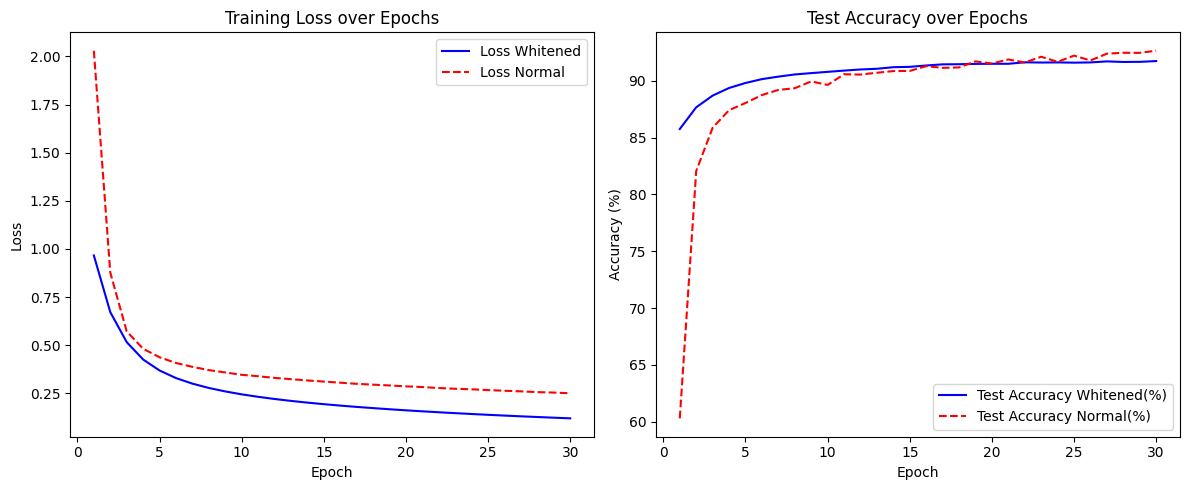

In [11]:
# Visualization of training progress
epochs = range(1, len(train_losses_normal) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_whitened, 'b-', label='Loss Whitened')
plt.plot(epochs, train_losses_normal, 'r--', label='Loss Normal')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies_whitened], 'b-', label='Test Accuracy Whitened(%)')
plt.plot(epochs, [acc * 100 for acc in test_accuracies_normal], 'r--', label='Test Accuracy Normal(%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Visualizing the Gradient Alignment

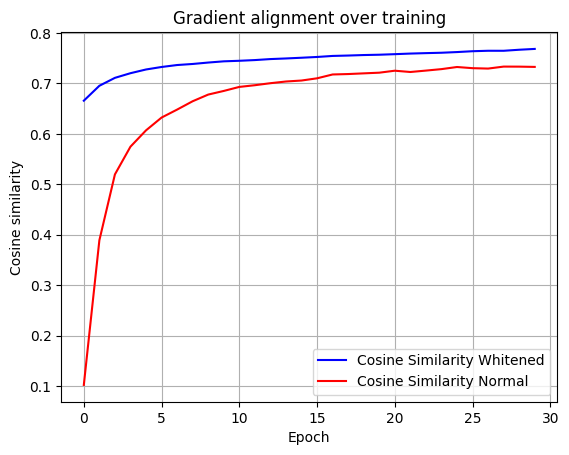

In [12]:
# Visualization of Gradient Alignment

plt.plot(gradient_alignments_whitened, 'b-', label = 'Cosine Similarity Whitened')
plt.plot(gradient_alignments_normal, 'r-', label = 'Cosine Similarity Normal')
plt.xlabel("Epoch")
plt.ylabel("Cosine similarity")
plt.title("Gradient alignment over training")
plt.grid(True)
plt.legend()
plt.show()